# Tarea 7. Tabular general
## Arnoldo Fernando Chue Sánchez

**Indicaciones**

Tomar el dataset de vinos y hacer una red neuronal para predecir el color y la calidad. Las métricas para evaluar esto con accuracy para color y L1 para la calidad. Para el conjunto de entrenamiento y validación se debe usar la columna is_valid del mismo dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import fastai.tabular.all as ft

import pandas as pd 
import numpy as np
from itertools import accumulate

Vamos a leer el dataset

In [2]:
df1 = pd.read_csv("wines.csv")
df1

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,is_valid
0,7.0,0.43,0.36,1.6,0.089,14.0,37.0,0.99615,3.34,0.56,9.2,6,red,False
1,7.6,0.68,0.02,1.3,0.072,9.0,20.0,0.99650,3.17,1.08,9.2,4,red,False
2,8.7,0.52,0.09,2.5,0.091,20.0,49.0,0.99760,3.34,0.86,10.6,7,red,False
3,6.0,0.42,0.41,12.4,0.032,50.0,179.0,0.99622,3.14,0.60,9.7,5,white,False
4,6.1,0.32,0.24,1.5,0.036,38.0,124.0,0.98980,3.29,0.42,12.4,7,white,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.6,0.25,0.33,8.5,0.042,29.0,141.0,0.99546,3.28,0.60,10.4,5,white,False
6493,5.9,0.25,0.19,12.4,0.047,50.0,162.0,0.99730,3.35,0.38,9.5,5,white,False
6494,7.3,0.74,0.08,1.7,0.094,10.0,45.0,0.99576,3.24,0.50,9.8,5,red,False
6495,6.6,0.22,0.23,17.3,0.047,37.0,118.0,0.99906,3.08,0.46,8.8,6,white,False


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
 13  is_valid              6497 non-null   bool   
dtypes: bool(1), float64(11), int64(1), object(1)
memory usage: 666.3+ KB


Veamos de qué tamaño tenemos los conjuntos de entrenamiento y validación

In [4]:
df1["is_valid"].value_counts()

is_valid
False    5848
True      649
Name: count, dtype: int64

Exploremos un poco el dataset para ver que no se nos esté pasando algo

In [5]:
df1.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
df1["color"].value_counts()

color
white    4898
red      1599
Name: count, dtype: int64

Parece que no hay outliers a primera vista. Así que vamos a traer las funciones de lo que necesitamos: el preprocesamiento de las variables categóricas y continuas que vamos a predecir, la función de pérdida y las métricas

In [7]:
class Numericalizer:
    def __init__(self, series:pd.Series):
        series = series.astype(str)
        self.series = series
        self.idx2cat = sorted(list(set(series)))
        self.cat2idx = {x:i for i,x in enumerate(self.idx2cat)}
        self.num_series = series.apply(lambda x: self.cat2idx[x]).astype(np.float32)
    
    def num_cats(self):
        return len(self.idx2cat)
    
    def __call__(self):
        return self.num_series
    
    def unapply(self, s:pd.Series):
        return s.astype(int).apply(lambda x: self.idx2cat[x])

class PreprocessY:
    def __init__(self, df:pd.DataFrame, y_cat:list, y_cont:list):
        self.y_cat, self.y_cont = y_cat, y_cont
        self.numericalizers = [Numericalizer(df[c]) for c in y_cat]
        self.mu_sd = []
        for n,c in zip(self.numericalizers, y_cat):
            df[c] = n()
            
        for c in y_cont:
            m,s = np.mean(df[c].values), np.std(df[c].values)
            df[c] = (df[c]-m)/s
            self.mu_sd.append((m,s))
    
    def y_len(self):
        return sum([n.num_cats() for n in self.numericalizers]) + len(self.y_cont)
    
    def unapply(self, df:pd.DataFrame):
        df_good = df.copy()
        for n,c in zip(self.numericalizers, self.y_cat):
            df_good[c] = n.unapply(df[c])
        for (m,s),c in zip(self.mu_sd, self.y_cont):
            df_good[c] = df_good[c]*s + m
        return df_good

from itertools import accumulate

def ycatcont(y,y_cat_names):
    n = len(y_cat_names)
    return y[:,:n].long(), y[:,n:]

class TabularLossFunc(nn.Module):
    def __init__(self, df:pd.DataFrame, 
                       y_cat_names:list, 
                       y_cont_names:list,
                       Yproc, 
                       cont_weight = 1.):
        super().__init__()
        self.y_cat_names = y_cat_names
        self.cont_n = len(y_cont_names)
        self.cat_n = [len(set(df[c])) for c in y_cat_names]
        self.psums = [0] + list(accumulate(self.cat_n))
        self.cat_loss = 0
        self.cont_loss = 0
        self.cont_weight = cont_weight
    
    def _divide(self, yp:torch.FloatTensor, y:torch.FloatTensor):
        P = self.psums
        y_cat, y_cont = ycatcont(y,self.y_cat_names)
        yp_cat = [yp[:,a:b] for a,b in zip(P,P[1:])]
        yp_cont = yp[:,-self.cont_n:]
        return yp_cat, yp_cont, y_cat, y_cont
        
    def __call__(self, yp:torch.FloatTensor, y:torch.FloatTensor):
        yp_cat, yp_cont, y_cat, y_cont = self._divide(yp,y)
        self.cat_loss = sum([F.cross_entropy(yp_c, y_cat[:,i]) for i,yp_c in enumerate(yp_cat)])
        self.cont_loss = self.cont_weight*F.mse_loss(yp_cont, y_cont)
        return self.cat_loss + self.cont_loss
    
    
    def accuracy(self, i:int):
        def func(yp, y):
            yp_cat, yp_cont, y_cat, y_cont = self._divide(yp,y)
            return ft.accuracy(yp_cat[i],y_cat[:,i])
        func.__name__ = f"accuracy_{self.y_cat_names[i]}"
        return func
    
    def mse(self, yp:torch.FloatTensor, y:torch.FloatTensor):
        yp_cat, yp_cont, y_cat, y_cont = self._divide(yp,y)
        return F.mse_loss(yp_cont,y_cont)
    
    def l1(self, yp:torch.FloatTensor, y:torch.FloatTensor):
        yp_cat, yp_cont, y_cat, y_cont = self._divide(yp,y)
        return F.l1_loss(yp_cont,y_cont)
    
    def catloss(self, yp:torch.FloatTensor, y:torch.FloatTensor):
        return self.cat_loss
    
    def contloss(self, yp:torch.FloatTensor, y:torch.FloatTensor):
        return self.cont_loss

def fix_model(learn:ft.Learner, Yproc:PreprocessY):
    nin = learn.model.layers[-1][0].in_features
    nout = Yproc.y_len()
    
    learn.model.layers[-1] = nn.Linear(nin, nout)

Vamos a separar cada columna en listas de lo que tenemos

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
 13  is_valid              6497 non-null   bool   
dtypes: bool(1), float64(11), int64(1), object(1)
memory usage: 666.3+ KB


In [9]:
df1.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color', 'is_valid'],
      dtype='object')

In [10]:
cont_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
y_cat_names = ['color']
y_cont_names = ['quality']

In [11]:
Yproc = PreprocessY(df1, y_cat_names, y_cont_names)

Ahora podemos cargar los datos

In [12]:
src = ft.TabularPandas(df1.copy(),
                       procs=[ft.Normalize],
                       cont_names=cont_names,
                       y_names=y_cat_names + y_cont_names,
                       splits=ft.FuncSplitter(lambda x: df1.iloc[x, -1])(ft.range_of(df1))
)

dls = src.dataloaders(bs=64)

Generamos la función de pérdida

In [ ]:
loss_func = TabularLossFunc(df1, y_cat_names, y_cont_names, Yproc, cont_weight=1)

metrics = [loss_func.accuracy(i) for i, _ in enumerate(y_cat_names)] + [loss_func.l1, loss_func.mse] # personalmente quiero ver también el mse

In [ ]:
learn1 = ft.tabular_learner(dls,
                            layers=[512,512], # con dos capas densas hemos visto que es suficiente
                            opt_func = ft.Adam, # voy a usar Adam porque parece que en datos tabulares funciona mejor que ranger
                            cbs = [ft.GradientClip], # evitamos problemas con el gradiente
                            loss_func = loss_func,
                            metrics=metrics)

In [39]:
learn1.summary()

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 11             
BatchNorm1d                               22         True      
____________________________________________________________________________
                     64 x 512            
Linear                                    5632       True      
ReLU                                                           
BatchNorm1d                               1024       True      
Linear                                    262144     True      
ReLU                                                           
BatchNorm1d                               1024       True      
____________________________________________________________________________
                     64 x 2              
Linear                                    1026       True      
____________________________________________________________________________

Total params: 270,872
Total tra

Arreglamos el tema de la salida de la red neuronal

In [40]:
fix_model(learn1, Yproc)

In [41]:
learn1.summary()

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 11             
BatchNorm1d                               22         True      
____________________________________________________________________________
                     64 x 512            
Linear                                    5632       True      
ReLU                                                           
BatchNorm1d                               1024       True      
Linear                                    262144     True      
ReLU                                                           
BatchNorm1d                               1024       True      
____________________________________________________________________________
                     64 x 3              
Linear                                    1539       True      
____________________________________________________________________________

Total params: 271,385
Total tra

c:\Users\Fernando\anaconda3\envs\redes\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **

SuggestedLRs(valley=0.0006918309954926372)

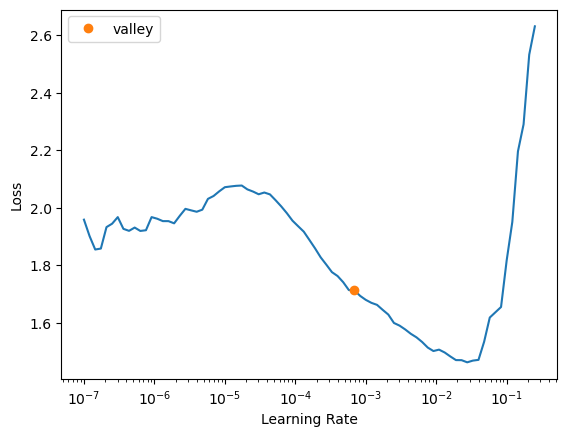

In [42]:
learn1.lr_find()

In [43]:
learn1.fit_one_cycle(10, 0.0001)

epoch,train_loss,valid_loss,accuracy_color,l1,mse,time
0,1.323031,0.920377,0.935285,0.639019,0.662550,00:01
1,0.893822,0.722419,0.989214,0.641527,0.642063,00:01
2,0.738552,0.631741,0.995377,0.617590,0.595925,00:01
3,0.656917,0.626040,0.996918,0.612279,0.599471,00:01
4,0.616257,0.620617,0.996918,0.608975,0.598095,00:01
5,0.615492,0.565545,0.996918,0.586491,0.546696,00:01
6,0.589739,0.541625,0.996918,0.573525,0.526212,00:01
7,0.595084,0.534603,0.996918,0.568238,0.519405,00:01
8,0.606475,0.531199,0.996918,0.567631,0.516096,00:01
9,0.571280,0.526540,0.996918,0.565278,0.512021,00:01


In [45]:
df1["quality"].describe()

count    6.497000e+03
mean    -3.015733e-16
std      1.000077e+00
min     -3.227687e+00
25%     -9.372296e-01
50%      2.079990e-01
75%      2.079990e-01
max      3.643685e+00
Name: quality, dtype: float64

Como podemos ver la red aprendió la predicción del color casi a la perfección. En cuanto a la L1 logró bajarla casi tanto como la función de pérdida general. A nivel de predicción con MSE vemos que no es tan preciso: si el rango de la calidad está entre -3.2 y 3.6 y se equivoca por un poco más de +-2, no es una regresión tan buena.

En ese caso podemos compararlo con un XGBoost para regresión

In [1]:
import pandas as pd
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df2 = pd.read_csv("wines.csv")

In [8]:
train_data = df2[~df2["is_valid"]].iloc[:,:-1]
valid_data = df2[df2["is_valid"]].iloc[:,:-1]

Y_train, Y_valid = train_data["quality"], valid_data["quality"]
X_train, X_valid = train_data.drop(["quality", "color"], axis=1), valid_data.drop(["quality", "color"], axis=1)

In [10]:
model = XGBRFRegressor(objective='reg:squarederror')
model.fit(X_train, Y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [11]:
Y_pred = model.predict(X_valid)
mse = mean_squared_error(Y_valid, Y_pred)
print(f"MSE {mse}")

MSE 0.4492049783439847


Como podemos ver, a nivel de regresión XGBoost le ganó por muchísimo a la red neuronal. Su única desventaja es que no puede hacer simultáneamente la clasificación y la regresión.

Con esto podemos notar que en datos tabulares y en determinadas circunstancias, las redes neuronales pueden perder en contra de ensambles 